In [1]:
# Model name as saved to gcs (it can be found in the model_name config key in wandb)
# wandb run: sleek-shadow-57
MODEL_NAME = "20220529-164031_03_tacotron_8khz_overfit__TacotronTTS"
LOCAL_MODEL_DIR = 'copied_models'

In [2]:
# Access project root dir
import git
import os
root_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

os.chdir(root_dir) # Ugly way to get access to imports but this way is also easier for ginconfig

In [3]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython
import tensorflow as tf
import subprocess

import prepare_data
import training
import cloud_training
import utils
import models
import gin

gin.parse_config_file('config/cloud_gpu.gin')
gin.parse_config_file('config/experiments/03_tacotron_8khz_overfit.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')

gsutil = os.path.dirname(gin.query_parameter('gcloud.gcloud_path')) + '/gsutil'
gcs_model_path = gin.query_parameter('gcloud_remote_training.gcs_model_path')

2022-05-29 23:31:04.523376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 23:31:04.523498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [4]:
train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

batch = list(train_dataset.take(1))[0]
spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)

2022-05-29 23:31:05.724620: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


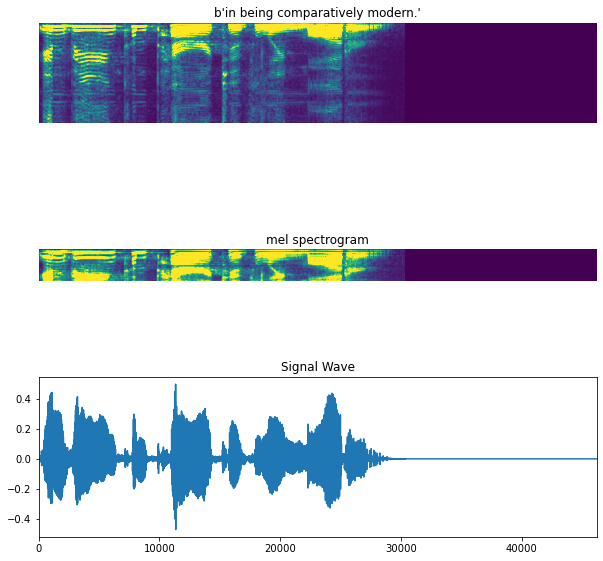

In [5]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
ax.imshow(np.transpose(spectrogram), vmax=1)
ax.set_title(transcription)
ax.axis("off")

ax = plt.subplot(3, 1, 2)
ax.imshow(np.transpose(mel_spec), vmax=1)
ax.set_title('mel spectrogram')
ax.axis("off")

ax = plt.subplot(3, 1, 3)
plt.plot(np.transpose(audio))
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
    
IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
plt.show()


In [6]:
# Download model and load it
cmd = [gsutil, '-m', 'cp', '-r', gcs_model_path + MODEL_NAME + '*', LOCAL_MODEL_DIR]
res = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [7]:
tts = models.TacotronTTS()
tts.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/final')

# model after first epoch
tts_0 = models.TacotronTTS()
tts_0.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_0')

In [16]:
GEN_FRAMES = 600

def summarize_mel_stats(mel_spec, new_mel_spec):
    ref_spec = mel_spec[:GEN_FRAMES,:].flatten()
    pred_spec = new_mel_spec[0].numpy().flatten()
    print(f'L1 {np.abs(pred_spec - ref_spec).mean()}')
    return pd.DataFrame({
        'mel_spec': mel_spec[:GEN_FRAMES,:].flatten(),
        'predicted_mel_spec': new_mel_spec[0].numpy().flatten()
    }).describe()

def mel_spec_viz(mel_spec, extra_title=''):
    ax = plt.subplot(2, 1, 1)
    ax.imshow(np.transpose(mel_spec[0]), vmax=1)
    ax.set_title('predicted mel spectrogram' + extra_title)
    ax.axis("off")

    ax = plt.subplot(2, 1, 2)
    ax.imshow(np.transpose(mel_spec[0]))
    ax.set_title('predicted mel spectrogram normalized' + extra_title)
    ax.axis("off")
    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(encoded[0]))
    ax.set_title('encoded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(embed[0]))
    ax.set_title('embedded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(pre_net[0]))
    ax.set_title('pre_net transcription')
    ax.axis("off")

    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    mask = input != tf.constant(-1, dtype=tf.int64)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)
    conv_bank = tts.tacotron_encoder.cbhg.conv_bank(pre_net)
    pooling = tts.tacotron_encoder.cbhg.pooling(conv_bank)
    conv_proj1 = tts.tacotron_encoder.cbhg.conv_proj1(pooling)
    conv_proj2 = tts.tacotron_encoder.cbhg.conv_proj2(conv_proj1)
    pre_rnn = pre_net + conv_proj2
    rnn = tts.tacotron_encoder.cbhg.rnn_encoder(pre_rnn, mask=mask)
    proj = tts.tacotron_encoder.cbhg.proj(rnn)

    plt.figure(figsize=(14, 8))
    
    data_sets = [
        encoded, embed, pre_net, conv_bank, pooling,
        conv_proj1, conv_proj2, pre_rnn, rnn, proj
    ]
    captions = [
        'encoded', 'embedded', 'pre_net', 'conv_bank', 'pooling',
        'conv_proj1', 'conv_proj2', 'pre_rnn', 'rnn', 'proj'
    ]
    
    for ix, (caption, data) in enumerate(zip(captions, data_sets)):
        ax = plt.subplot(1, len(data_sets), ix+1)
        ax.imshow(np.transpose(data[0]))
        ax.set_title(caption)
        ax.axis("off")
        
    plt.show()

In [9]:
# Generate mel_specs

input = tf.expand_dims(enc_transcription[enc_transcription!=-1], 0)
new_mel_spec = tts.decode(input, GEN_FRAMES)
new_mel_spec_0 = tts_0.decode(input, GEN_FRAMES)

In [10]:
summarize_mel_stats(mel_spec, new_mel_spec)

L1 0.42641374468803406


,mel_spec,predicted_mel_spec
count,24000.000000,24000.000000
mean,0.516777,0.488711
std,0.527056,0.193521
min,0.000000,0.045573
25%,0.098989,0.350617
50%,0.375960,0.442770
75%,0.765602,0.608056
max,3.915968,0.953668


In [12]:
summarize_mel_stats(mel_spec, new_mel_spec_0)

L1 0.4908595383167267


,mel_spec,predicted_mel_spec
count,24000.000000,24000.000000
mean,0.516777,0.047774
std,0.527056,0.058711
min,0.000000,0.000000
25%,0.098989,0.000000
50%,0.375960,0.023259
75%,0.765602,0.076738
max,3.915968,0.241921


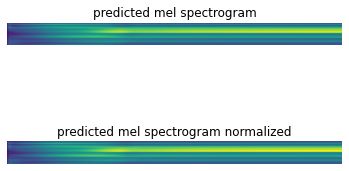

In [17]:
mel_spec_viz(new_mel_spec)

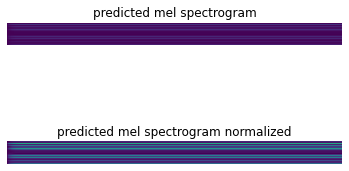

In [18]:
mel_spec_viz(new_mel_spec_0)

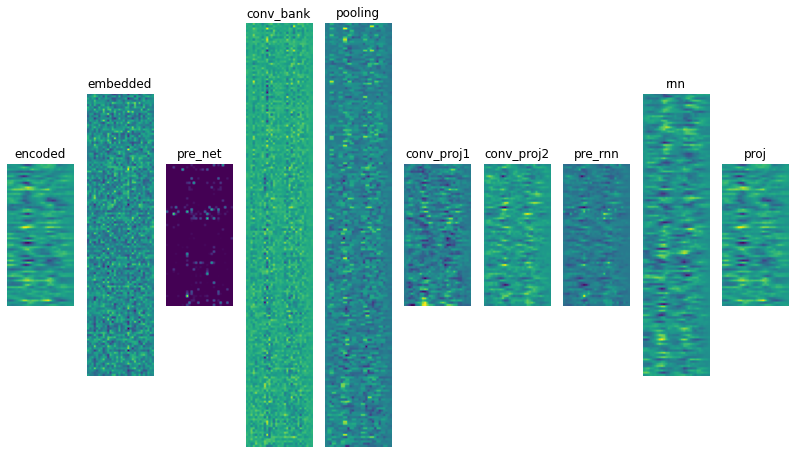

In [20]:
encoder_viz(tts, input)

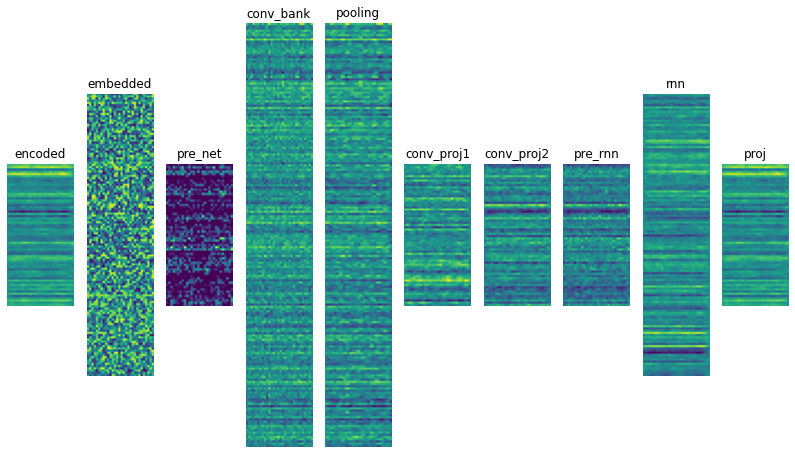

In [21]:
encoder_viz(tts_0, input)

In [22]:
def visualize_attention_states(att_rnn_states):
    data = tf.concat([s[0] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('cell states')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[1] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[2] for s in att_rnn_states], 0)

    plt.figure(figsize=(16, 14))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention state (alignments)')
    ax.axis("off")
    plt.show()

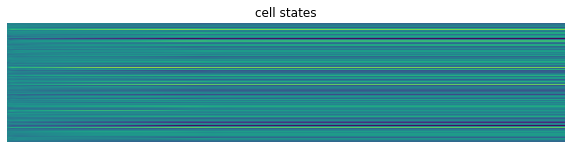

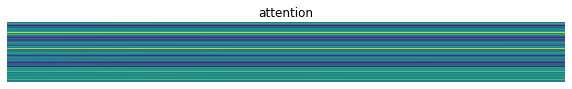

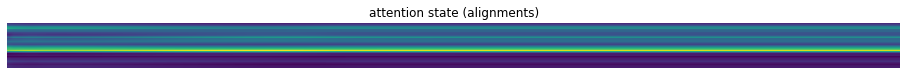

In [23]:
# TRAINED TTS
_, states = tts.decode(input, GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

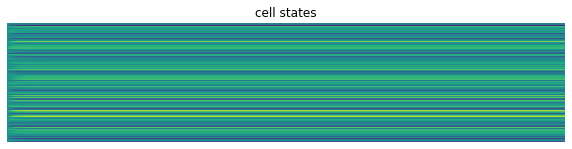

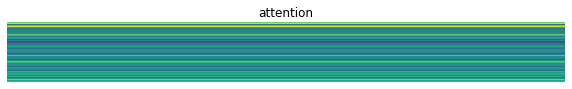

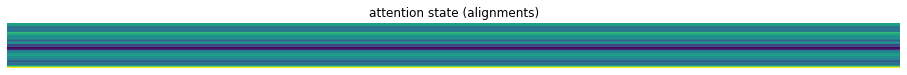

In [33]:
# TRAINED TTS epoch 0
_, states = tts_0.decode(input, GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

# Quick and dirty check of attention calculation (Ugly)

In [31]:
def decode(model, encoder_inputs, num_frames):
    encoded_inputs, seq_lengths = model.tacotron_encoder(encoder_inputs)
    state = None
    model.tacotron_mel_decoder.setup_attended(encoded_inputs, seq_lengths)

    input_frame = tf.zeros((tf.shape(encoder_inputs)[0], 1, model.mel_bins))
    input_frame_cell = tf.zeros((tf.shape(encoder_inputs)[0], model.mel_bins))
    output = []
    
    # Only batch dimension matters
    state = model.tacotron_mel_decoder.rnn_cell.get_initial_state(input_frame_cell)
    state_d1 = model.tacotron_mel_decoder.decode_rnn1.get_initial_state(input_frame)
    state_d2 = model.tacotron_mel_decoder.decode_rnn2.get_initial_state(input_frame)

    inp = input_frame_cell
    for i in range(num_frames):
        print(state.alignments[0,:4])
        inp = model.tacotron_mel_decoder.pre_net(inp)
        inp = model.tacotron_mel_decoder.rnn_cell._cell_input_fn(inp, state.attention)
        outp, new_cell_state = model.tacotron_mel_decoder.rnn_cell._cell(inp, state.cell_state)
        attention, alignments, next_attention_state = model.tacotron_mel_decoder.rnn_cell._attention_fn(
            model.tacotron_mel_decoder.attention_mechanism,
            outp,
            state.attention_state,
            None
        )
        state = state.clone(
            attention=attention, alignments=alignments,
            attention_state=next_attention_state, cell_state=new_cell_state
        )
        x = tf.expand_dims(outp,1)
        x1, state_d1 = model.tacotron_mel_decoder.decode_rnn1(x, initial_state=state_d1)
        x2, state_d2 = model.tacotron_mel_decoder.decode_rnn2(x+x1, initial_state=state_d2)
        x = model.tacotron_mel_decoder.proj(x+x1+x2)

        
        inp = tf.squeeze(x, 1)

In [32]:
decode(tts, input, 50)

tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0.02953315 0.03442656 0.04196707 0.04606888], shape=(4,), dtype=float32)
tf.Tensor([0.02906039 0.03337739 0.04072252 0.04547608], shape=(4,), dtype=float32)
tf.Tensor([0.0289945  0.03349971 0.04087211 0.04522193], shape=(4,), dtype=float32)
tf.Tensor([0.0288166  0.03341288 0.04075364 0.04478113], shape=(4,), dtype=float32)
tf.Tensor([0.0287185  0.03335013 0.04064205 0.04449823], shape=(4,), dtype=float32)
tf.Tensor([0.02859692 0.03319762 0.04045008 0.04427066], shape=(4,), dtype=float32)
tf.Tensor([0.02853302 0.03310729 0.04034397 0.04417022], shape=(4,), dtype=float32)
tf.Tensor([0.02847941 0.03302267 0.04025142 0.04410409], shape=(4,), dtype=float32)
tf.Tensor([0.02842777 0.03294695 0.04017011 0.04404546], shape=(4,), dtype=float32)
tf.Tensor([0.02834526 0.03283806 0.04005067 0.04394547], shape=(4,), dtype=float32)
tf.Tensor([0.0282464  0.03271046 0.03990825 0.04381925], shape=(4,), dtype=float32)
tf.Tensor([0.02815092 0.

We can see attention stays in a steady state, just a quick and dirty check (it would make sense to compare the output with what is computed with the production code path).